In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
df = pd.read_csv('gdrive/My Drive/reddit_worldnews_start_to_2016-11-22.csv')[:100000]

df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [4]:
df.author.value_counts().head(20)

igeldard            3918
twolf1              1799
maxwellhill         1644
SolInvictus         1581
DougBolivar         1321
galt1776            1266
DrRichardCranium    1214
alllie               947
davidreiss666        940
blackstar9000        696
Kaffir               671
koavf                648
MrTulip              607
Orangutan            589
silence_hr           587
mjanes               556
jips                 544
misterAction         529
spainguy             482
ajehals              446
Name: author, dtype: int64

In [0]:
from gensim.models import Word2Vec

text = [t.lower() for t in df.title]

model = Word2Vec(text, size=300, window=5, sg=1)

In [0]:
def doc_vectorizer(text, model):
  doc_vec = 0
  count = 0

  if len(text) == 1:
    return model[text]

  for t in text:
    try:
      word_vec = model[t]
      doc_vec = doc_vec + word_vec
      count += 1
    except:
      pass
  
  doc_vec = doc_vec / count
  return doc_vec

In [7]:
df['score'] = df.up_votes - df.down_votes

df_grouped = df.groupby('author')['title'].apply(lambda x: ' '.join(x)).reset_index()
df_grouped['mean_score'] = df.groupby('author')['score'].mean().values

df_grouped.head()

,author,title,mean_score
0,---sniff---,"The wife of Mir Hossein Mousavi, Ahmadinejad’s...",20.400000
1,--TacoLoco--,No explosives found in the bomb strapped to ...,5.000000
2,-____-,Palestinian sets record for longest imprisonme...,10.000000
3,-_o_0__0_o_-,Sweden wants to force ISPs to save user data S...,5.666667
4,-repick,Four Norwegian soldiers killed in Afghanistan,0.000000


In [8]:
author_vectors = [doc_vectorizer(t.lower(), model) for t in df_grouped.title]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(author_vectors)

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

In [0]:
df_grouped['tsne_x'] = tsne_results[:,0]
df_grouped['tsne_y'] = tsne_results[:,1]
df_grouped['score_category'] = np.where(df_grouped.mean_score >= np.mean(df_grouped.mean_score) + np.std(df_grouped.mean_score),
                                        'high_scorer',
                                        np.where(df_grouped.mean_score <= np.mean(df_grouped.mean_score) - 10,
                                                 'low_scorer','mid_scorer')
                                        )

In [11]:
df_grouped.score_category.value_counts()

low_scorer     13563
mid_scorer      1952
high_scorer      753
Name: score_category, dtype: int64

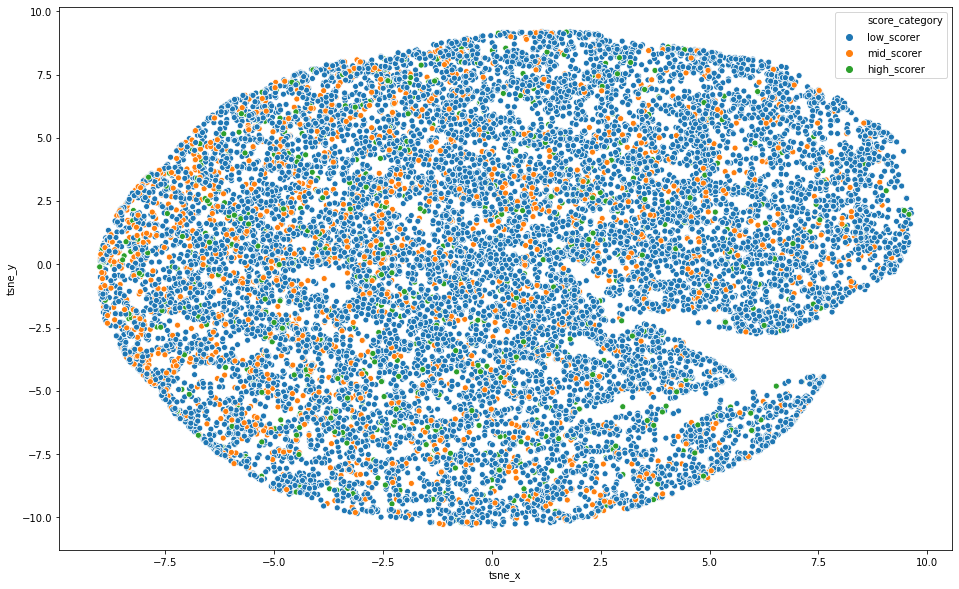

In [12]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne_x', y='tsne_y',
    hue="score_category",
    #palette=sns.color_palette(, 3),
    data=df_grouped,
    legend="full")

In [0]:
from sklearn.metrics.pairwise import cosine_distances

author_distances = pd.DataFrame(
    cosine_distances(author_vectors, author_vectors)
)

In [14]:
author_distances.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16228,16229,16230,16231,16232,16233,16234,16235,16236,16237,16238,16239,16240,16241,16242,16243,16244,16245,16246,16247,16248,16249,16250,16251,16252,16253,16254,16255,16256,16257,16258,16259,16260,16261,16262,16263,16264,16265,16266,16267
0,0.000000,0.000815,0.000965,0.001226,0.002338,0.001071,0.001656,0.009475,0.002074,0.004994,0.000159,0.002993,0.037676,0.000510,0.009386,0.005155,0.002218,0.001790,0.005787,0.000424,0.004168,0.013047,0.004319,0.003248,0.003312,0.001909,0.003223,0.001761,0.002992,0.004612,0.002007,0.000521,0.037550,0.000494,0.003259,0.000690,0.002776,0.000609,0.004828,0.006595,...,0.001352,0.000516,0.003515,0.004373,0.003007,0.000918,0.007565,0.000857,0.000881,0.001119,0.001565,0.003693,0.010403,0.062823,0.007362,0.002086,0.002029,0.001742,0.003120,0.002669,0.001763,0.001515,0.003454,0.002362,0.001542,0.001419,0.001070,0.001996,0.004021,0.000334,0.003673,0.002722,0.001854,0.004637,0.001617,0.009724,0.000287,0.003038,0.006143,0.000271
1,0.000815,0.000000,0.000762,0.001599,0.003970,0.002052,0.002487,0.010945,0.002615,0.005421,0.000827,0.003396,0.038276,0.001275,0.011021,0.006557,0.002355,0.002837,0.006485,0.001276,0.006214,0.014082,0.005717,0.004642,0.003050,0.002723,0.003631,0.003208,0.004881,0.004929,0.002786,0.000943,0.039898,0.001363,0.003348,0.001310,0.003656,0.001491,0.005514,0.007300,...,0.002395,0.001294,0.005815,0.004112,0.004710,0.001743,0.009126,0.001764,0.001583,0.002214,0.002982,0.005269,0.011412,0.063989,0.007322,0.003212,0.003175,0.001126,0.004490,0.004209,0.002717,0.001279,0.004502,0.003780,0.002931,0.002564,0.001564,0.002453,0.005585,0.001078,0.005571,0.003236,0.002757,0.005269,0.002829,0.011067,0.000932,0.004337,0.006263,0.000920
2,0.000965,0.000762,0.000000,0.001731,0.003506,0.002106,0.002306,0.011805,0.003159,0.005116,0.001058,0.004177,0.040701,0.001674,0.011318,0.006097,0.002721,0.002609,0.006880,0.001202,0.004789,0.015802,0.006533,0.004867,0.003113,0.003164,0.004122,0.002957,0.003893,0.005788,0.003028,0.000782,0.040778,0.001545,0.004452,0.001285,0.003005,0.001850,0.006280,0.006765,...,0.002192,0.001542,0.004938,0.005976,0.004389,0.002270,0.008766,0.002001,0.002049,0.002911,0.003261,0.004616,0.012471,0.063970,0.007498,0.002168,0.003495,0.002044,0.003913,0.004373,0.003330,0.001338,0.005009,0.003453,0.002793,0.002350,0.001438,0.003096,0.004341,0.001208,0.004681,0.003022,0.002988,0.005423,0.002438,0.011139,0.001015,0.004567,0.007535,0.001329
3,0.001226,0.001599,0.001731,0.000000,0.004472,0.001643,0.003020,0.010812,0.004396,0.005605,0.001166,0.005818,0.036579,0.002512,0.012143,0.005720,0.001653,0.002463,0.008684,0.001676,0.003146,0.015331,0.006200,0.005804,0.004377,0.002444,0.003605,0.002379,0.003607,0.005626,0.002430,0.001061,0.043131,0.001923,0.004594,0.001677,0.003239,0.001480,0.005578,0.006877,...,0.003431,0.001891,0.004558,0.006682,0.005185,0.002327,0.007988,0.002210,0.002602,0.002549,0.003226,0.005535,0.013998,0.067877,0.009117,0.002674,0.003208,0.003114,0.003989,0.004612,0.003034,0.002328,0.004118,0.002976,0.002485,0.001983,0.001635,0.002205,0.003272,0.001486,0.004131,0.003223,0.003163,0.005931,0.002385,0.010696,0.000911,0.004888,0.007054,0.001601
4,0.002338,0.003970,0.003506,0.004472,0.000000,0.004012,0.005090,0.015886,0.005086,0.010111,0.002496,0.003886,0.040101,0.002903,0.012100,0.005336,0.005967,0.003175,0.005993,0.002587,0.005444,0.016913,0.007980,0.006416,0.006632,0.006086,0.006162,0.004258,0.004838,0.008999,0.005119,0.003251,0.041256,0.002932,0.007569,0.002875,0.004363,0.003773,0.007437,0.011309,...,0.002096,0.003696,0.005476,0.008131,0.005763,0.004088,0.011626,0.003963,0.003576,0.002587,0.004112,0.006525,0.014265,0.070902,0.012875,0.002596,0.005082,0.004984,0.003428,0.003032,0.003386,0.003725,0.005180,0.004044,0.003988,0.004726,0.004280,0.005305,0.006421,0.002668,0.005687,0.005998,0.003204,0.008712,0.004458,0.014603,0.002766,0.003464,0.008037,0.002809


In [17]:
author_distances_v2 = author_distances.replace(0, np.nan)
author_distances_v2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16228,16229,16230,16231,16232,16233,16234,16235,16236,16237,16238,16239,16240,16241,16242,16243,16244,16245,16246,16247,16248,16249,16250,16251,16252,16253,16254,16255,16256,16257,16258,16259,16260,16261,16262,16263,16264,16265,16266,16267
0,NaN,0.000815,0.000965,0.001226,0.002338,0.001071,0.001656,0.009475,0.002074,0.004994,0.000159,0.002993,0.037676,0.000510,0.009386,0.005155,0.002218,0.001790,0.005787,0.000424,0.004168,0.013047,0.004319,0.003248,0.003312,0.001909,0.003223,0.001761,0.002992,0.004612,0.002007,0.000521,0.037550,0.000494,0.003259,0.000690,0.002776,0.000609,0.004828,0.006595,...,0.001352,0.000516,0.003515,0.004373,0.003007,0.000918,0.007565,0.000857,0.000881,0.001119,0.001565,0.003693,0.010403,0.062823,0.007362,0.002086,0.002029,0.001742,0.003120,0.002669,0.001763,0.001515,0.003454,0.002362,0.001542,0.001419,0.001070,0.001996,0.004021,0.000334,0.003673,0.002722,0.001854,0.004637,0.001617,0.009724,0.000287,0.003038,0.006143,0.000271
1,0.000815,NaN,0.000762,0.001599,0.003970,0.002052,0.002487,0.010945,0.002615,0.005421,0.000827,0.003396,0.038276,0.001275,0.011021,0.006557,0.002355,0.002837,0.006485,0.001276,0.006214,0.014082,0.005717,0.004642,0.003050,0.002723,0.003631,0.003208,0.004881,0.004929,0.002786,0.000943,0.039898,0.001363,0.003348,0.001310,0.003656,0.001491,0.005514,0.007300,...,0.002395,0.001294,0.005815,0.004112,0.004710,0.001743,0.009126,0.001764,0.001583,0.002214,0.002982,0.005269,0.011412,0.063989,0.007322,0.003212,0.003175,0.001126,0.004490,0.004209,0.002717,0.001279,0.004502,0.003780,0.002931,0.002564,0.001564,0.002453,0.005585,0.001078,0.005571,0.003236,0.002757,0.005269,0.002829,0.011067,0.000932,0.004337,0.006263,0.000920
2,0.000965,0.000762,NaN,0.001731,0.003506,0.002106,0.002306,0.011805,0.003159,0.005116,0.001058,0.004177,0.040701,0.001674,0.011318,0.006097,0.002721,0.002609,0.006880,0.001202,0.004789,0.015802,0.006533,0.004867,0.003113,0.003164,0.004122,0.002957,0.003893,0.005788,0.003028,0.000782,0.040778,0.001545,0.004452,0.001285,0.003005,0.001850,0.006280,0.006765,...,0.002192,0.001542,0.004938,0.005976,0.004389,0.002270,0.008766,0.002001,0.002049,0.002911,0.003261,0.004616,0.012471,0.063970,0.007498,0.002168,0.003495,0.002044,0.003913,0.004373,0.003330,0.001338,0.005009,0.003453,0.002793,0.002350,0.001438,0.003096,0.004341,0.001208,0.004681,0.003022,0.002988,0.005423,0.002438,0.011139,0.001015,0.004567,0.007535,0.001329
3,0.001226,0.001599,0.001731,NaN,0.004472,0.001643,0.003020,0.010812,0.004396,0.005605,0.001166,0.005818,0.036579,0.002512,0.012143,0.005720,0.001653,0.002463,0.008684,0.001676,0.003146,0.015331,0.006200,0.005804,0.004377,0.002444,0.003605,0.002379,0.003607,0.005626,0.002430,0.001061,0.043131,0.001923,0.004594,0.001677,0.003239,0.001480,0.005578,0.006877,...,0.003431,0.001891,0.004558,0.006682,0.005185,0.002327,0.007988,0.002210,0.002602,0.002549,0.003226,0.005535,0.013998,0.067877,0.009117,0.002674,0.003208,0.003114,0.003989,0.004612,0.003034,0.002328,0.004118,0.002976,0.002485,0.001983,0.001635,0.002205,0.003272,0.001486,0.004131,0.003223,0.003163,0.005931,0.002385,0.010696,0.000911,0.004888,0.007054,0.001601
4,0.002338,0.003970,0.003506,0.004472,NaN,0.004012,0.005090,0.015886,0.005086,0.010111,0.002496,0.003886,0.040101,0.002903,0.012100,0.005336,0.005967,0.003175,0.005993,0.002587,0.005444,0.016913,0.007980,0.006416,0.006632,0.006086,0.006162,0.004258,0.004838,0.008999,0.005119,0.003251,0.041256,0.002932,0.007569,0.002875,0.004363,0.003773,0.007437,0.011309,...,0.002096,0.003696,0.005476,0.008131,0.005763,0.004088,0.011626,0.003963,0.003576,0.002587,0.004112,0.006525,0.014265,0.070902,0.012875,0.002596,0.005082,0.004984,0.003428,0.003032,0.003386,0.003725,0.005180,0.004044,0.003988,0.004726,0.004280,0.005305,0.006421,0.002668,0.005687,0.005998,0.003204,0.008712,0.004458,0.014603,0.002766,0.003464,0.008037,0.002809


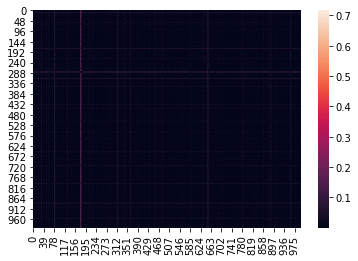

In [19]:
#Crashes if full dataframe
sns.heatmap(author_distances_v2.iloc[0:1000,0:1000])